# Library Imports / Setup

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import os
import numpy as np
import random
import pandas as pd
import gc
import time
import matplotlib.pyplot as plt
import tensorflow as tf
print('Tensorflow Version:', tf.__version__)

Tensorflow Version: 2.0.0


In [0]:
# change current working directory
os.chdir('/content/drive/My Drive/CISC 6000: Deep Learning/Final Project (Deep Learning - Fall 2019)')
os.getcwd()

'/content/drive/My Drive/CISC 6000: Deep Learning/Final Project (Deep Learning - Fall 2019)'

In [0]:
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb, deltaE_ciede2000, deltaE_cie76
import albumentations as A
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from mpl_toolkits.axes_grid1 import ImageGrid

In [0]:
import tensorflow_datasets as tfds
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, RepeatVector, concatenate, UpSampling2D
from tensorflow.keras.layers import Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model, Sequence

In [0]:
# seed for randoom number generator
def seed_everything(SEED):
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    random.seed(SEED)
seed_everything(6000)

In [0]:
BATCH_SIZE = 100
TARGET_SIZE = (256, 256)

# Define Inception ResNet V2 Model

In [0]:
#full_inres = InceptionResNetV2(weights='imagenet', include_top=True)
#inres_model = Model(full_inres.input, full_inres.layers[-2].output) # get model without softmax layer
inres_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=TARGET_SIZE+(3,), pooling='avg')
print('INRES MODEL INPUT  SHAPE:', inres_model.input.shape)
print('INRES MODEL OUTPUT SHAPE:', inres_model.output.shape)

INRES MODEL INPUT  SHAPE: (None, 256, 256, 3)
INRES MODEL OUTPUT SHAPE: (None, 1536)


# Data Processing Functions

Notes:
take image
convert it first to lab

for l --> 2 * l / 100 - 1
for ab --> ab / 127
image embedding -- take lab -- concatenate it 3 times -- get predictions

plot:
gray scale image --> take input l component (X) and convert it to RGB grayscale
    lab = np.squeeze(255 * (img_l + 1) / 2)
    return color.gray2rgb(lab) / 255

output image (prediction) --> take l component and predicted ab component -- get one rgb image from this
    lab = np.empty([*img_l.shape[0:2], 3])
    lab[:, :, 0] = np.squeeze(((img_l + 1) * 50)) (l --> add 1 and then multiply 50 to this)
    lab[:, :, 1:] = img_ab * 127 (pred -- multiply back with 127)
    return color.lab2rgb(lab)

true image --> do same as above -- but combine l with original Y to get true image



In [0]:
def getImageArray(FOLDER_PATH, target_size=TARGET_SIZE, isColor=True, isSplit=True, test_split=0.1):
    img_files_lst = os.listdir(FOLDER_PATH)
    img_files_lst.sort()
    num_images = len(img_files_lst)
    x = []
    if isColor == True:
        color_mode = 'rgb'
    else:
        color_mode = 'grayscale'
    for img in img_files_lst:
        img_arr = img_to_array(load_img(path=FOLDER_PATH + '/' + img, target_size=target_size, color_mode=color_mode)) * 1.0/255
        x.append(img_arr)
    x = np.array(x)
    print('Finished converting', str(num_images), 'images as numpy arrays!')
    print('Image pixels are in range', x.min(), 'to', x.max())
    if isSplit == True:
        train, test = train_test_split(x, test_size=test_split)
        print('Train Shape:', train.shape)
        print('Test  Shape:', test.shape)
        return train, test
    return x

In [0]:
def getProcessedData(arr):
    arr_lab = rgb2lab(arr)
    X = 2 * arr_lab[:, :, :, 0] / 100 - 1 # scale to [-1, 1]
    X = np.expand_dims(X, axis=3)
    Y = arr_lab[:, :, :, 1:] / 128 # scale to [-1, 1]
    X_inres = np.concatenate([X, X, X], axis=3)
    X_inres = inres_model.predict(X_inres)
    print('Shape of X:', X.shape, 'with pixels in range', X.min(), 'to', X.max())
    print('Shape of X_inres:', X.shape, 'with pixels in range', X_inres.min(), 'to', X_inres.max())
    print('Shape of Y:', Y.shape, 'with pixels in range', Y.min(), 'to', Y.max())
    return X, X_inres, Y

In [0]:
class DataGenerator(Sequence):
    def __init__(self, datagen):
        self.datagen = datagen
        self.on_epoch_end()
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.datagen)
    
    def on_epoch_end(self):
        self.datagen.on_epoch_end()
    
    def __getitem__(self, idx):
        'Generates one batch of data'
        batch = self.datagen[idx]
        batch = resize(batch, output_shape=(len(batch), 256, 256, 3))
        lab_batch = rgb2lab(batch)
        X = 2 * lab_batch[:, :, :, 0] / 100 - 1 # scale to [-1, 1]
        X = np.expand_dims(X, axis=3)
        Y = lab_batch[:, :, :, 1:] / 128 # scale to [-1, 1]
        X_inres = np.concatenate([X, X, X], axis=3)
        X_inres = inres_model.predict(X_inres)
        return [X, X_inres], Y

# Model Functions

In [0]:
def conv_block(x, num_filters, kernel_size, num_strides, activation, kernel_initializer, kernel_regularizer, addBN, addDR, dRate, name):
    x = Conv2D(filters=num_filters, kernel_size=kernel_size, strides=num_strides, 
               kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer, 
               padding='same', name=name)(x)
    if addBN == True:
        x = BatchNormalization(name='bn_' + name)(x)
    if addDR == True:
        x = Dropout(dRate, name='dr_' + name)(x)
    x = Activation(activation, name='act_' + name)(x)
    return x

In [0]:
def convT_block(x, num_filters, kernel_size, num_strides, activation, kernel_initializer, kernel_regularizer, addBN, addDR, dRate, name):
    x = Conv2DTranspose(filters=num_filters, kernel_size=kernel_size, strides=num_strides, 
                        kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer, 
                        padding='same', name=name)(x)
    if addBN == True:
        x = BatchNormalization(name='bn_' + name)(x)
    if addDR == True:
        x = Dropout(dRate, name='dr_' + name)(x)
    x = Activation(activation, name='act_' + name)(x)
    return x

In [0]:
def buildModel(input_shape, input_shape_inres, num_filters, kernel_size, num_layers, activation, kernel_initializer, kernel_regularizer, addBN, addDR, dRate, optimizer, loss, model_name):
    inp = Input(shape=input_shape, name='input')
    x = inp
    
    # encoder
    for i in range(num_layers):
        x = conv_block(x, num_filters=num_filters, kernel_size=kernel_size, num_strides=2,
                       activation=activation, kernel_initializer=kernel_initializer, 
                       kernel_regularizer=kernel_regularizer, addBN=addBN, addDR=addDR, dRate=dRate, 
                       name='en_stridePool_' + str(num_filters))
        num_filters = num_filters * 2
        x = conv_block(x, num_filters=num_filters, kernel_size=kernel_size, num_strides=1,
                       activation=activation, kernel_initializer=kernel_initializer, 
                       kernel_regularizer=kernel_regularizer, addBN=addBN, addDR=addDR, dRate=dRate, 
                       name='en_' + str(num_filters))
    encoder_shape = K.int_shape(x)

    # inres
    inres_inp = Input(shape=input_shape_inres, name='inres_input')
    inres_out = Dense(units=int(input_shape_inres[-1] / 3), activation=activation, 
                      kernel_initializer=kernel_initializer, name='inres_dense')(inres_inp)
    inres_out = RepeatVector(encoder_shape[1] * encoder_shape[2], name='inres_repeat')(inres_out)
    inres_out = Reshape((encoder_shape[1], encoder_shape[2], int(input_shape_inres[-1] / 3)), name='inres_reshape')(inres_out)
    inres_out = concatenate([x, inres_out], axis=3, name='inres_concat')
    num_filters = int(num_filters / 2)
    x = conv_block(inres_out, num_filters=num_filters, kernel_size=1, num_strides=1,
                   activation=activation, kernel_initializer=kernel_initializer, 
                   kernel_regularizer=kernel_regularizer, addBN=addBN, addDR=addDR, dRate=dRate, 
                   name='inres_conv' + str(num_filters))
    
    # decoder
    for i in range(num_layers):
        num_filters = int(num_filters / 2)
        x = conv_block(x, num_filters=num_filters, kernel_size=kernel_size, num_strides=1,
                       activation=activation, kernel_initializer=kernel_initializer, 
                       kernel_regularizer=kernel_regularizer, addBN=addBN, addDR=addDR, dRate=dRate, 
                        name='de_' + str(num_filters))
        x = UpSampling2D(name='de_upsample' + str(num_filters))(x)
    
    out = conv_block(x, num_filters=2, kernel_size=kernel_size, num_strides=1,
                     activation='tanh', kernel_initializer=kernel_initializer, 
                     kernel_regularizer=kernel_regularizer, addBN=False, addDR=False, dRate=0.0, 
                     name='output')
    
    model = Model([inp, inres_inp], out, name=model_name)
    model.compile(optimizer=optimizer, loss=loss, metrics=['mae'])
    return model

In [0]:
def fit(model, epochs, train_gen, val_gen, verbose, callbacks_list):
    start = time.time()
    history = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(train_gen), verbose=verbose, 
                                  validation_data=val_gen, validation_steps=len(val_gen), callbacks=callbacks_list)
    end = time.time() - start
    print('\n\tTotal Training Time:', np.round(end, 2), 'seconds')
    print('Train Loss:', np.round(np.mean(history.history['loss']), 4), 
          '\tMAE:', np.round(np.mean(history.history['mae']), 4))
    print('Val   Loss:', np.round(np.mean(history.history['val_loss']), 4), 
          '\tMAE:', np.round(np.mean(history.history['val_mae']), 4))
    return history, model

# Evaluation Functions

In [0]:
def plotHistory(history):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], 'r--', label='train_loss')
    plt.plot(history.history['val_loss'], 'b-', label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Learning Curve')
    plt.legend(loc='best')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], 'r--', label='train_mae')
    plt.plot(history.history['val_mae'], 'b-', label='val_mae')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.title('MAE Learning Curve')
    plt.legend(loc='best')
    plt.show()

In [0]:
def predict(model, X, X_inres, Y):
    eval_results = model.evaluate([X, X_inres], Y, verbose=0)
    print('Test  Loss:', np.round(eval_results[0], 4), '\tMAE:', np.round(eval_results[1], 4))
    pred = model.predict([X, X_inres])
    canvas = np.zeros(X.shape[:-1]+(3,))
    canvas[:, :, :, 0] = (X[:, :, :, 0] + 1) * 50
    canvas[:, :, :, 1:] = pred * 128
    return canvas

In [0]:
def getSSIM(true, pred):
    return np.mean(tf.image.ssim(tf.convert_to_tensor(true, dtype='float32'), 
                                 tf.convert_to_tensor(pred, dtype='float32'), 
                                 max_val=1.0))

In [0]:
def plotResult(true, pred_arr_list, pred_label_list, num_imgs):
    for i in range(num_imgs):
        plt.figure(figsize=(20, 20))
        plt.subplot(1, len(pred_arr_list) + 2, 1)
        plt.imshow(rgb2gray(true[i]), cmap='gray')
        plt.axis('off')
        plt.title('Grayscale')
        for j in range(len(pred_arr_list)):
            plt.subplot(1, len(pred_arr_list) + 2, j+2)
            plt.imshow(lab2rgb(pred_arr_list[j][i]))
            plt.axis('off')
            plt.title(pred_label_list[j])
        plt.subplot(1, len(pred_arr_list) + 2, len(pred_arr_list) + 2)
        plt.imshow(true[i])
        plt.axis('off')
        plt.title('Ground Truth')
        plt.show()

# Final Model Training (in Batches)

## Visual Genome Dataset (256 x 256 - 5K Images)

In [0]:
train = np.load('./DATA/vg-test-5K-256.npy')
train, test = train_test_split(train, test_size=0.1)
train, val = train_test_split(train, test_size=0.2)
print('Train Shape:', train.shape)
print('Val   Shape:', val.shape)
print('Test  Shape:', test.shape)

Train Shape: (3600, 256, 256, 3)
Val   Shape: (900, 256, 256, 3)
Test  Shape: (500, 256, 256, 3)


In [0]:
train_generator = DataGenerator(img_arr=train, batch_size=BATCH_SIZE, isInres=True)
val_generator = DataGenerator(img_arr=val, batch_size=BATCH_SIZE, isInres=True)

In [0]:
test_lab = rgb2lab(test * 1.0/255)
test_X = test_lab[:, :, :, 0] / 100
test_X = np.expand_dims(test_X, axis=3)
test_Y = test_lab[:, :, :, 1:] / 128

test_inres = test * 1.0/255
test_inres = np.expand_dims(rgb2gray(test_inres), axis=3)
test_inres = np.concatenate([test_inres, test_inres, test_inres], axis=3)
test_inres = inres_model.predict(test_inres)

print('\nShape of TEST:      ', test.shape, 'with pixels in range', test.min(), 'to', test.max())
print('Shape of TEST INRES:', test_inres.shape, 'with pixels in range', test_inres.min(), 'to', test_inres.max())
print('Shape of TEST LAB:  ', test_lab.shape, 'with pixels in range', test_lab.min(), 'to', test_lab.max())
print('Shape of TEST X:    ', test_X.shape, 'with pixels in range', test_X.min(), 'to', test_X.max())
print('Shape of TEST Y:    ', test_Y.shape, 'with pixels in range', test_Y.min(), 'to', test_Y.max())


Shape of TEST:       (500, 256, 256, 3) with pixels in range 0.0 to 255.0
Shape of TEST INRES: (500, 1536) with pixels in range 0.0 to 7.108236
Shape of TEST LAB:   (500, 256, 256, 3) with pixels in range -107.13462056753032 to 100.0
Shape of TEST X:     (500, 256, 256, 1) with pixels in range 0.0 to 1.0
Shape of TEST Y:     (500, 256, 256, 2) with pixels in range -0.8369892231838306 to 0.7414199807926092


Model: "fin"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
en_stridePool_64 (Conv2D)       (None, 128, 128, 64) 640         input[0][0]                      
__________________________________________________________________________________________________
bn_en_stridePool_64 (BatchNorma (None, 128, 128, 64) 256         en_stridePool_64[0][0]           
__________________________________________________________________________________________________
act_en_stridePool_64 (Activatio (None, 128, 128, 64) 0           bn_en_stridePool_64[0][0]        
________________________________________________________________________________________________

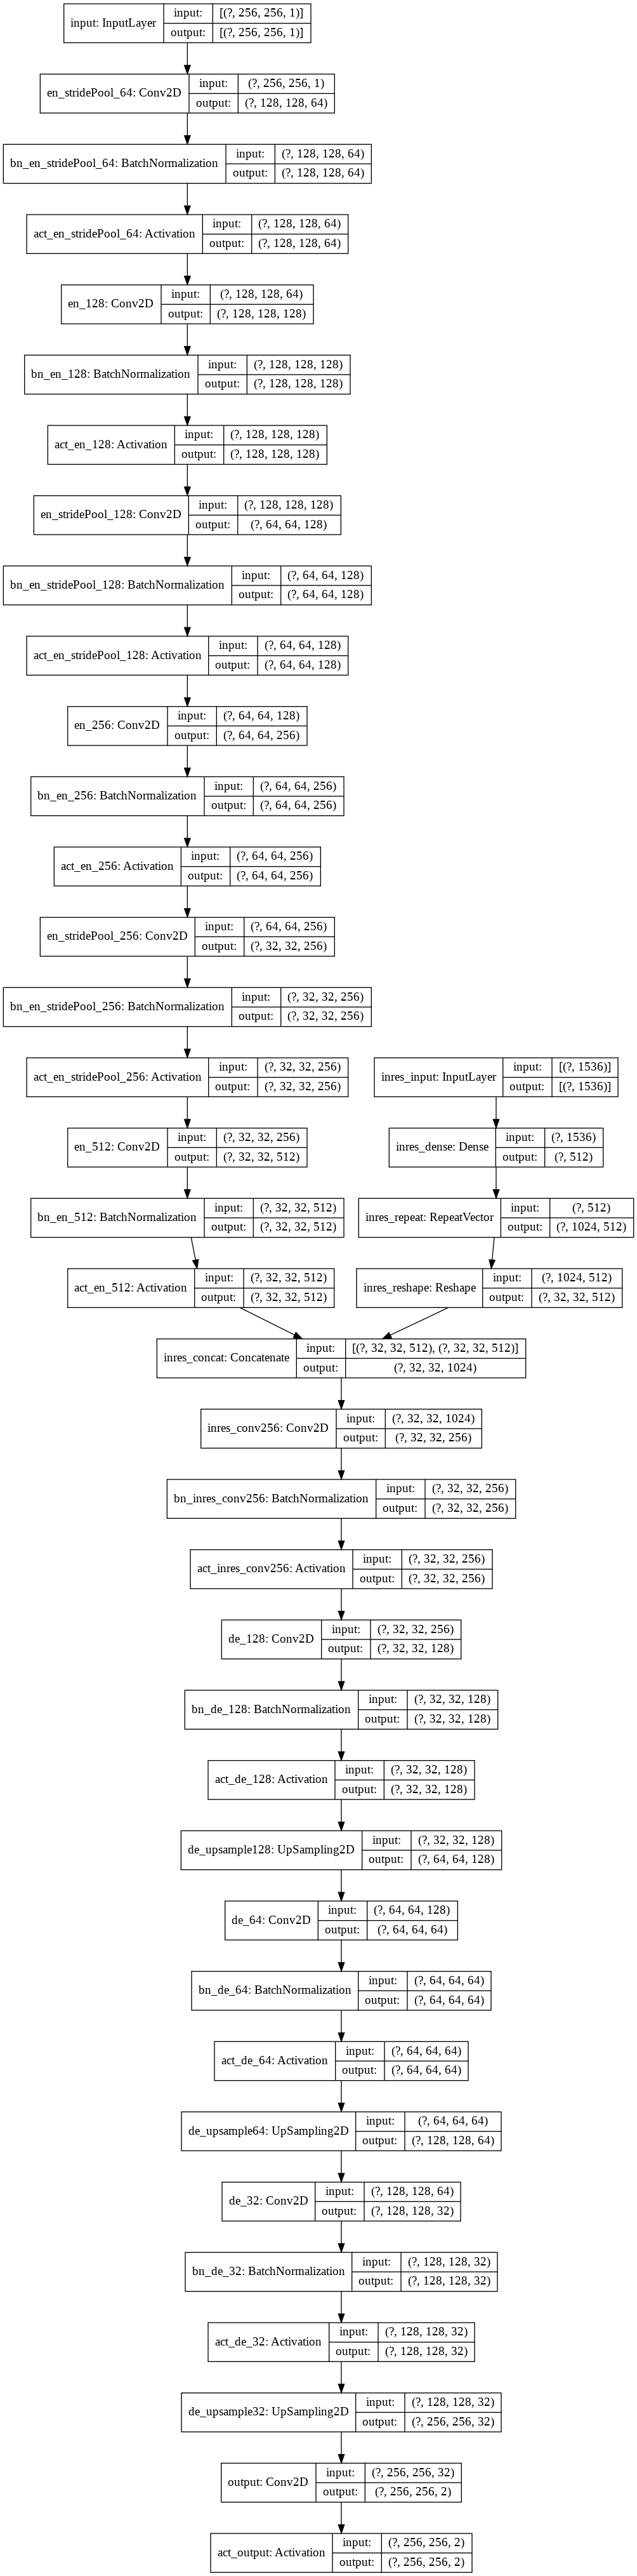

In [0]:
fin = buildModel(input_shape=TARGET_SIZE+(1,), input_shape_inres=(inres_model.output.shape[-1],), 
                 num_filters=64, kernel_size=3, num_layers=3, activation='relu', 
                 kernel_initializer='he_normal', kernel_regularizer=None, 
                 addBN=True, addDR=False, dRate=0.0, optimizer='adam', loss='mse', model_name='fin')
fin.summary()
plot_model(fin, show_shapes=True)

Epoch 1/300
57/57 [==============================] - 106s 2s/step - loss: 0.0352 - mae: 0.1092 - val_loss: 0.2169 - val_mae: 0.3521
Epoch 2/300
57/57 [==============================] - 88s 2s/step - loss: 0.0132 - mae: 0.0778 - val_loss: 0.0176 - val_mae: 0.0913
Epoch 3/300
57/57 [==============================] - 88s 2s/step - loss: 0.0120 - mae: 0.0751 - val_loss: 0.0146 - val_mae: 0.0811
Epoch 4/300
57/57 [==============================] - 88s 2s/step - loss: 0.0115 - mae: 0.0731 - val_loss: 0.0147 - val_mae: 0.0835
Epoch 5/300
57/57 [==============================] - 89s 2s/step - loss: 0.0109 - mae: 0.0713 - val_loss: 0.0141 - val_mae: 0.0827
Epoch 6/300
57/57 [==============================] - 89s 2s/step - loss: 0.0105 - mae: 0.0700 - val_loss: 0.0140 - val_mae: 0.0794
Epoch 7/300
57/57 [==============================] - 89s 2s/step - loss: 0.0101 - mae: 0.0688 - val_loss: 0.0146 - val_mae: 0.0802
Epoch 8/300
57/57 [==============================] - 91s 2s/step - loss: 0.0099 - 

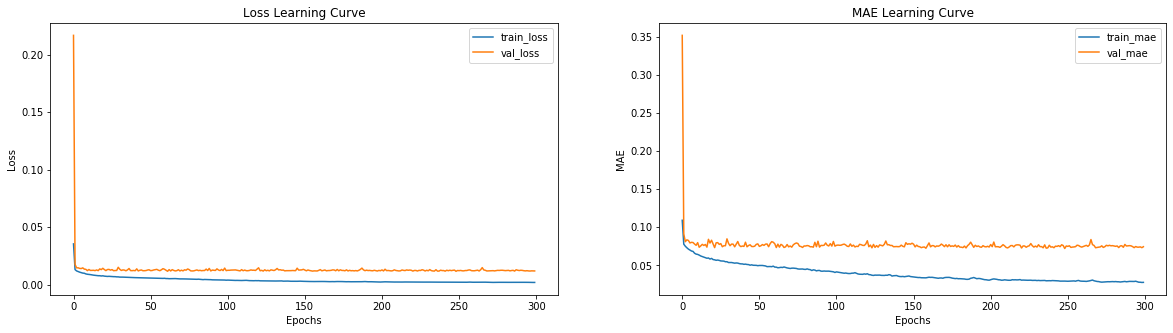

Loss: 0.0125 	MAE: 0.0753
SSIM: 0.14080295
DelE: [[[113.43856049 134.04650128 159.89990704 ... 101.99758494  99.57921067
   102.66737054]
  [158.46148772 117.63792294 156.20961264 ... 100.65870799  98.59034735
    99.64320056]
  [174.10062753 146.51157096 151.77272563 ... 100.1032533  100.01875764
    98.98872382]
  ...
  [107.91220666  15.36597045 100.72208193 ... 140.75926013 144.14971907
   136.56182164]
  [ 79.05189149 107.73120233  98.1357356  ... 147.66406635 144.30435662
   135.85364617]
  [ 44.23050377 106.10174108 119.94747516 ... 140.93974692 141.37745878
   140.20930839]]

 [[124.24795334 123.59105682 124.03357031 ... 124.79825762 124.72248003
   124.85142953]
  [124.29481309 122.30459709 122.71669263 ... 124.62488995 123.91122966
   124.47486516]
  [125.49145868 122.16775813 123.24042303 ... 124.08771328 124.13110295
   124.0166853 ]
  ...
  [ 46.69117118  83.17972626  41.24302243 ...  28.12410666  46.3183398
    31.9886757 ]
  [ 58.15983076  84.97135583  40.84941258 ...  4

In [0]:
history, fin = fit(model=fin, epochs=300, train_gen=train_generator, val_gen=val_generator, verbose=1, 
                   callbacks_list=[ModelCheckpoint('./L2BN_VG_weights_best.hdf5', save_best_only=False, save_weights_only=False)])
plotHistory(history)
pred_fin = predict(model=fin, X_inres=test_inres, X=test_X, Y=test_Y)
print('SSIM:', getSSIM(test, pred_fin))
print('DelE:', deltaE_ciede2000(rgb2lab(test), rgb2lab(pred_fin)))

In [0]:
fin.load_weights('./L2BN_VG_weights_best.hdf5')
pred_fin = predict(model=fin, X_inres=test_inres, X=test_X, Y=test_Y)


Loss: 0.0125 	MAE: 0.0753


In [0]:
plotResult(true=test, pred_arr_list=[pred_fin], pred_label_list=['L2 + BN'], num_imgs=50)

Output hidden; open in https://colab.research.google.com to view.

## Nature Dataset (256 x 256 - 1K Images)

In [0]:
train, test = getImageArray('./DATA/Flower-17')
test_X, test_inres, test_Y = getProcessedData(test)

Finished converting 1360 images as numpy arrays!
Image pixels are in range 0.0 to 1.0
Train Shape: (1224, 256, 256, 3)
Test  Shape: (136, 256, 256, 3)
Shape of X: (136, 256, 256, 1) with pixels in range -1.0 to 1.0
Shape of X_inres: (136, 256, 256, 1) with pixels in range 0.0 to 6.083651
Shape of Y: (136, 256, 256, 2) with pixels in range -0.6325375077942755 to 0.7381103302849863


In [0]:
train_datagen = ImageDataGenerator(data_format='channels_last', validation_split=0.2, 
                                   rotation_range=40, shear_range=0.2, zoom_range=0.2,
                                   width_shift_range=0.2, height_shift_range=0.2, 
                                   horizontal_flip=True, vertical_flip=True)

train_generator = DataGenerator(train_datagen.flow(train, batch_size=100, subset='training'))
val_generator = DataGenerator(train_datagen.flow(train, batch_size=100, subset='validation'))

In [0]:
fin = buildModel(input_shape=TARGET_SIZE+(1,), input_shape_inres=(inres_model.output.shape[-1],), 
                 num_filters=64, kernel_size=3, num_layers=3, activation='relu', 
                 kernel_initializer='he_normal', kernel_regularizer=None, 
                 addBN=True, addDR=False, dRate=0.0, optimizer='adam', loss='mse', model_name='fin')

Epoch 1/100
10/10 [==============================] - 49s 5s/step - loss: 0.1151 - mae: 0.2481 - val_loss: 0.9250 - val_mae: 0.9432
Epoch 2/100
10/10 [==============================] - 34s 3s/step - loss: 0.0296 - mae: 0.1278 - val_loss: 0.9267 - val_mae: 0.9444
Epoch 3/100
10/10 [==============================] - 36s 4s/step - loss: 0.0258 - mae: 0.1188 - val_loss: 0.9253 - val_mae: 0.9406
Epoch 4/100
10/10 [==============================] - 35s 4s/step - loss: 0.0245 - mae: 0.1147 - val_loss: 0.8802 - val_mae: 0.9023
Epoch 5/100
10/10 [==============================] - 36s 4s/step - loss: 0.0232 - mae: 0.1113 - val_loss: 0.7856 - val_mae: 0.8234
Epoch 6/100
10/10 [==============================] - 36s 4s/step - loss: 0.0225 - mae: 0.1101 - val_loss: 0.7384 - val_mae: 0.7647
Epoch 7/100
10/10 [==============================] - 36s 4s/step - loss: 0.0226 - mae: 0.1099 - val_loss: 0.4446 - val_mae: 0.5617
Epoch 8/100
10/10 [==============================] - 35s 4s/step - loss: 0.0221 - m

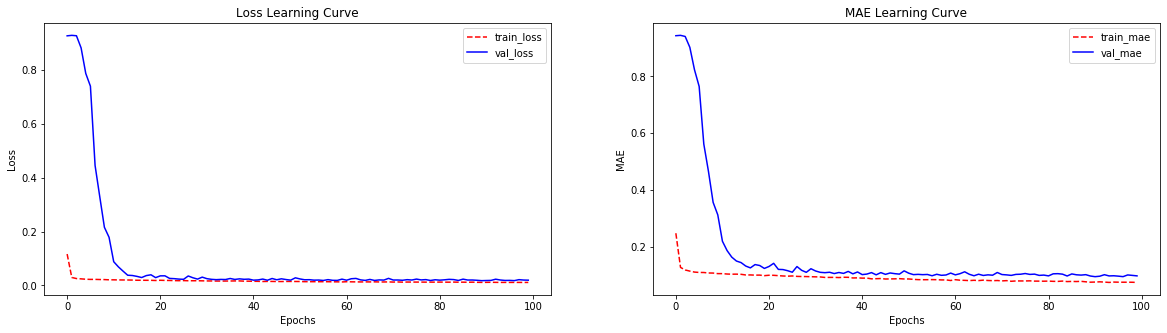

Loss: 0.0179 	MAE: 0.0938


In [0]:
history, fin = fit(model=fin, epochs=100, train_gen=train_generator, val_gen=val_generator, verbose=1, 
                   callbacks_list=[ModelCheckpoint('./flower_weights.hdf5', save_best_only=False, save_weights_only=False)])
plotHistory(history)
pred = predict(model=fin, X=test_X, X_inres=test_inres, Y=test_Y)

In [0]:
# plot prediction images
fig = plt.figure(figsize=(23, 100))
grid = ImageGrid(fig, 111, nrows_ncols=(int(np.floor(len(pred)/6)), 6), axes_pad=0.1)
for ax, im in zip(grid, pred):
    ax.imshow(lab2rgb(im))
    ax.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# plot prediction with ground truth
plotResult(true=test, pred_arr_list=[pred], pred_label_list=['Prediction'], num_imgs=50)

Output hidden; open in https://colab.research.google.com to view.

## Visual Genome Dataset (256 x 256 - 10K Images)

In [0]:
train = np.load('./DATA/vg-train-10K-256.npy')
train, test = train_test_split(train, test_size=0.1)
train, val = train_test_split(train, test_size=0.2)
train = train * 1.0/255
val = val * 1.0/255
test = test * 1.0/255
print('Train Shape:', train.shape)
print('Val   Shape:', val.shape)
print('Test  Shape:', test.shape)

Train Shape: (7200, 256, 256, 3)
Val   Shape: (1800, 256, 256, 3)
Test  Shape: (1000, 256, 256, 3)


In [0]:
test_X, test_inres, test_Y = getProcessedData(test)

Shape of X: (1000, 256, 256, 1) with pixels in range -1.0 to 1.0
Shape of X_inres: (1000, 256, 256, 1) with pixels in range 0.0 to 8.192011
Shape of Y: (1000, 256, 256, 2) with pixels in range -0.839167139751485 to 0.7544737829565198


In [0]:
train_datagen = ImageDataGenerator(data_format='channels_last', validation_split=0.2, 
                                   rotation_range=40, shear_range=0.2, zoom_range=0.2,
                                   width_shift_range=0.2, height_shift_range=0.2, 
                                   horizontal_flip=True, vertical_flip=True)

train_generator = DataGenerator(train_datagen.flow(train, batch_size=BATCH_SIZE, subset='training'))
val_generator = DataGenerator(train_datagen.flow(train, batch_size=BATCH_SIZE, subset='validation'))

In [0]:
def scheduler(epoch):
    if epoch < 20:
        return 0.001
    else:
        return 0.001 * np.exp(0.1 * (20 - epoch))

In [0]:
fin = buildModel(input_shape=TARGET_SIZE+(1,), input_shape_inres=(inres_model.output.shape[-1],), 
                 num_filters=64, kernel_size=3, num_layers=3, activation='relu', 
                 kernel_initializer='he_normal', kernel_regularizer=None, 
                 addBN=True, addDR=False, dRate=0.0, optimizer='adam', loss='mse', model_name='fin')

In [0]:
history, fin = fit(model=fin, epochs=500, train_gen=train_generator, val_gen=val_generator, verbose=1, 
                   callbacks_list=[ModelCheckpoint('./FIN-vg-10K-weights.hdf5', save_best_only=False, save_weights_only=False), 
                                   LearningRateScheduler(scheduler, verbose=1)])
plotHistory(history)
pred = predict(model=fin, X=test_X, X_inres=test_inres, Y=test_Y)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/500
58/58 [==============================] - 282s 5s/step - loss: 0.0302 - mae: 0.1039 - val_loss: 0.5674 - val_mae: 0.6533

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/500
58/58 [==============================] - 241s 4s/step - loss: 0.0119 - mae: 0.0741 - val_loss: 0.0233 - val_mae: 0.1055

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/500
58/58 [==============================] - 238s 4s/step - loss: 0.0115 - mae: 0.0725 - val_loss: 0.0125 - val_mae: 0.0783

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
Epoch 4/500
58/58 [==============================] - 236s 4s/step - loss: 0.0113 - mae: 0.0717 - val_loss: 0.0112 - val_mae: 0.0713

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001.
Epoch 5/500
58/58 [==============================] - 241s 4s/step - loss: 0.0112 - mae: 0.0717 - val_loss: 0.0120 - val_mae: 0.

KeyboardInterrupt: ignored

In [0]:
# plot val and train loss in 2 separate plots
plt.figure(figsize=(30, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'r-', label='train_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss (MSE)')
plt.legend(loc='best')
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], 'b-', label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Val Loss (MSE)')
plt.legend(loc='best')

In [0]:
fin.load_weights('./FIN-vg-10K-weights.hdf5')
pred = predict(model=fin, X=test_X, X_inres=test_inres, Y=test_Y)

Test  Loss: 0.0112 	MAE: 0.0697


In [0]:
# evaluate train and val performance
eval_results = fin.evaluate_generator(train_generator, verbose=0)
print('Train Loss:', np.round(eval_results[0], 4), '\tMAE:', np.round(eval_results[1], 4))
eval_results = fin.evaluate_generator(val_generator, verbose=0)
print('Val   Loss:', np.round(eval_results[0], 4), '\tMAE:', np.round(eval_results[1], 4))

Train Loss: 0.0081 	MAE: 0.0595
Val   Loss: 0.01 	MAE: 0.066


In [0]:
# plot prediction images
fig = plt.figure(figsize=(23, 300))
grid = ImageGrid(fig, 111, nrows_ncols=(30, 6), axes_pad=0.1)
for ax, im in zip(grid, pred[:180]):
    ax.imshow(lab2rgb(im))
    ax.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# plot prediction with ground truth
plotResult(true=test[:50], pred_arr_list=[pred[:50]], pred_label_list=['Prediction'], num_imgs=50)

Output hidden; open in https://colab.research.google.com to view.